<a href="https://drive.google.com/file/d/1b7tSyJBpWggHEBGdWa80JdKh7VNq2FEf/view?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m

# setting the seed
rng.current = 1
rng_bad.current = 1

In [106]:
samples = [rng() for _ in range(1000)]
random = [rng_bad() for _ in range(1000)]

### Problem 1
Implement serial test and apply to a `samples`

In [108]:

def split_into_pairs(sequence):
    # Разбиваем последовательность на пары
    return [(sequence[i], sequence[i+1]) for i in range(0, len(sequence)-1, 2)]

def create_contingency_table(pairs, bins=20):
    # Создаем таблицу сопряженности для пар точек
    x = [p[0] for p in pairs]
    y = [p[1] for p in pairs]
    H = np.histogram2d(x, y, bins=bins)[0]
    return H

k = 20
pairs = split_into_pairs(samples)
contingency_table = create_contingency_table(pairs, k)

# Создаем ожидаемые результаты с учетом общей суммы наблюдений
total_observations = contingency_table.sum()
f_exp = np.full((k, k), total_observations / (k*k))

chi2, p_value = stats.chisquare(contingency_table.flatten(), f_exp.flatten())

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")

Chi-square statistic: 386.40000000000003
P-value: 0.6653662117152015


### Permutation test

We again decompose the sequence $x_1, x_2, x_3, ..., x_{dn}$ into consecutive series of length $d$: $(x_1, ..., x_d), (x_{d+1}, x_{2d+d}), \ldots, (x_{nd-d+1}, x_{nd})$. A series of $d$ elements can be ordered in $d!$ ways and each way of ordering is equally probable. Hence the idea of the test is to count how many times each ordering occurs among $n$ series and apply the $\chi^2$ test.


### Problem 2*

Implement permutation test and apply to a `samples`

In [ ]:
# Your code here

### Problem 3

Provide a statistical test to show that `rng_bad` has problems but `rng_good` does not.

### Problem 4
Simulate a sample of 1000 from a discrete distribution on a set of digits $0, 1, 2, \ldots, 9$ with weights $0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2$. Construct a histogram from the sample. Optimise the algorithm by ordering the weights.

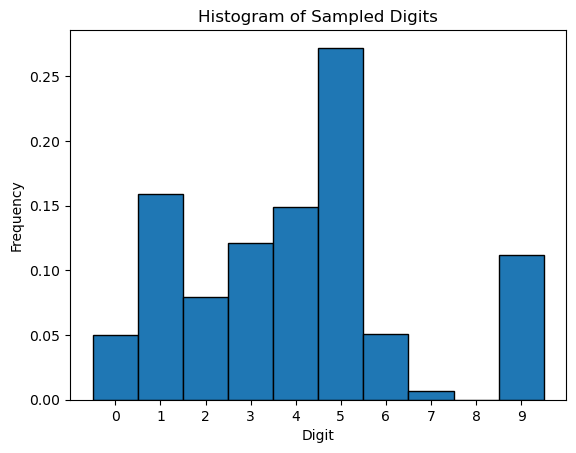

In [110]:

def discrete_sample(weights, size):
    """Генерирует выборку из дискретного, распределения используя обратное преобразование"""
    # Нормируем веса
    weights = np.array(weights) / np.sum(weights)
    
    # Вычисляем кумулятивную функцию распределения
    cdf = np.cumsum(weights)
    
    U = np.random.rand(size)
    
    # Используем двоичный поиск, чтобы найти соответствующую цифру для каждого равномерного случайного числа.
    samples = np.searchsorted(cdf, U)
    
    return samples

weights = [0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2]

sample = discrete_sample(weights, 1000)

plt.hist(sample, bins=np.arange(11) - 0.5, edgecolor='black', density=True)
plt.xticks(range(10))
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.title('Histogram of Sampled Digits')
plt.show()

### Problem 5
Simulate a sample of size 1000 from the distribution $\operatorname{Exp}(\lambda)$ using the Inverse transform method. Construct a sample histogram and an accurate plot of the distribution density.

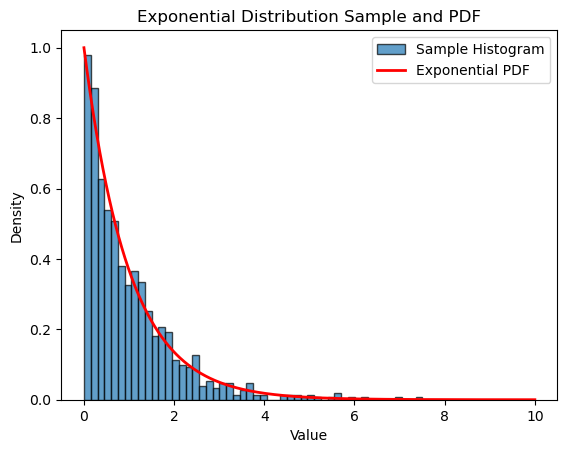

In [124]:

lambda_param = 1.0  # Параметр для экспоненциального распределения

cdf = lambda p, lam: -np.log(1 - p) / lam # Обратное распределение

U = np.random.rand(1000)

X = cdf(U, lambda_param) # Получаем нужную выборку

plt.hist(X, bins=50, density=True, edgecolor='black', alpha=0.7, label='Sample Histogram')

# Строим точную плотность экспоненциального распределения
x_values = np.linspace(0, 10, 1000)
pdf_values = stats.expon.pdf(x_values, scale=1/lambda_param)
plt.plot(x_values, pdf_values, 'r-', lw=2, label='Exponential PDF')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Exponential Distribution Sample and PDF')
plt.legend()
plt.show()

### Problem 6
Justify (orally) that the accept-reject method really samples from the required distribution. Simulate $1000$ points from the distribution with density $e^xcos^2x \cdot \mathbb{I}_{[-\frac\pi2, \frac\pi2]}$. Plot the sampled histogram on the sample and compare it with the plot of the exact density function.

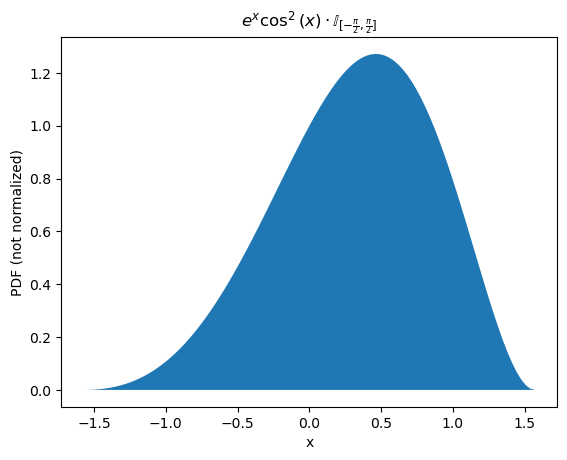

In [116]:
fig = plt.figure()

x = np.linspace(-np.pi/2, np.pi/2, 100)
density = np.exp(x) * np.cos(x) ** 2 # not normalized density!
plt.fill_between(x, 0, density)
plt.ylabel('PDF (not normalized)')
plt.xlabel('x')
plt.title(r'$e^x \cos^2(x) \cdot \mathbb{I}_{[-\frac{\pi}{2}, \frac{\pi}{2}]}$')

plt.show()

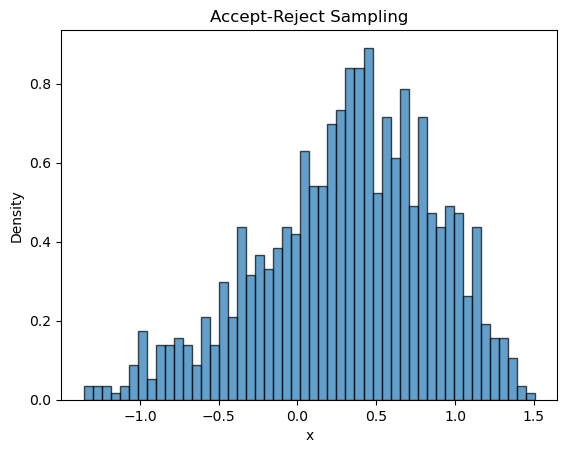

In [144]:

F = lambda x: np.exp(x) * (np.cos(x))**2

def proposal_distribution():
    '''Генерирует точку из вспомогательного распределения'''
    return np.random.uniform(-np.pi/2, np.pi/2)

# Ищем максимум F, чтобы определить коэффициент пропорциональности 
x_values = np.linspace(-np.pi/2, np.pi/2, 1000)
f_values = F(x_values)
M = np.max(f_values) / (1 / (np.pi))  

def accept_reject_sample(size):
    '''Создаёт выборку из подходящих значений'''
    samples = []
    while len(samples) < size:
        x = proposal_distribution()
        u = np.random.uniform(0, 1)
        if u <= F(x) / M:
            samples.append(x)
    return np.array(samples)

samples = accept_reject_sample(1000)

plt.hist(samples, bins=50, density=True, edgecolor='black', alpha=0.7, label='Sampled Histogram')

plt.xlabel('x')
plt.ylabel('Density')
plt.title('Accept-Reject Sampling')
plt.show()

### Problem 7
Model and depict a sample of 500 points uniformly distributed within a given triangle without using a selection method.

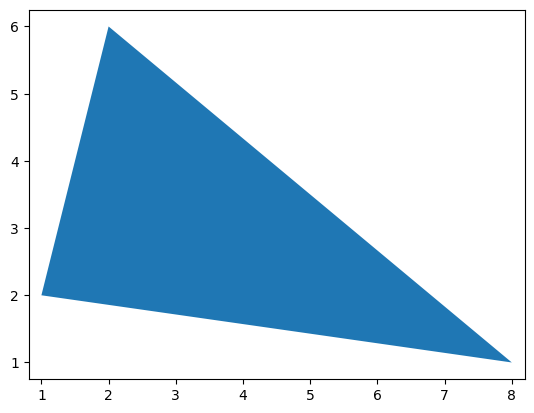

In [146]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig = plt.figure()

polygon = Polygon(xy=np.array([[1, 2], [2, 6], [8, 1]]), closed=True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.axis('equal')
plt.show()

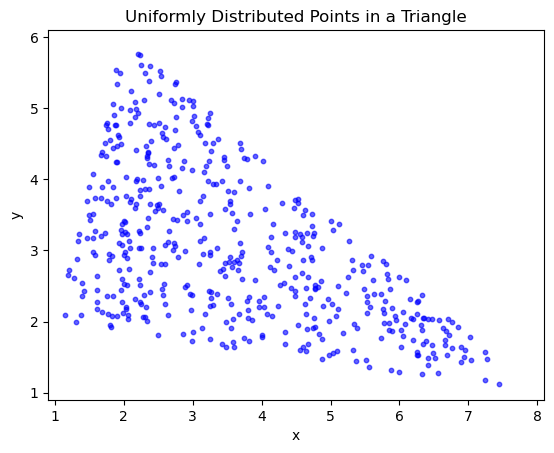

In [173]:

vertices = np.array([[1, 2], [2, 6], [8, 1]])
A, B, C = vertices

def uniform_triangle_sample(A, B, C, n):
    '''Генерирует 500 точек, равномерно распределенных внутри треугольника, используя преобразование координат'''
    u = np.random.rand(n)
    v = np.random.rand(n)
    mask = u + v > 1
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    points = A + u[:, np.newaxis] * (B - A) + v[:, np.newaxis] * (C - A)
    return points

points = uniform_triangle_sample(A, B, C, 500)

plt.scatter(points[:, 0], points[:, 1], s=10, color='blue', alpha=0.6)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Uniformly Distributed Points in a Triangle')
plt.axis((0.9, 8.1, 0.9, 6.1))
plt.show()

### Problem 8
Model without using the selection method a sample of $500$ points uniformly distributed inside the unit circle. Picture the obtained points. Do they really fill the circle uniformly?

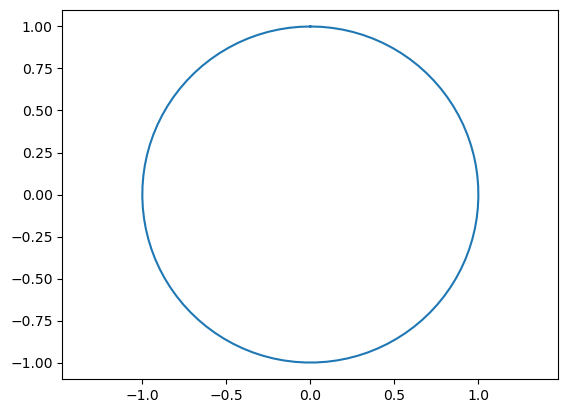

In [158]:
fig = plt.figure()

t = np.linspace(0, 2*np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

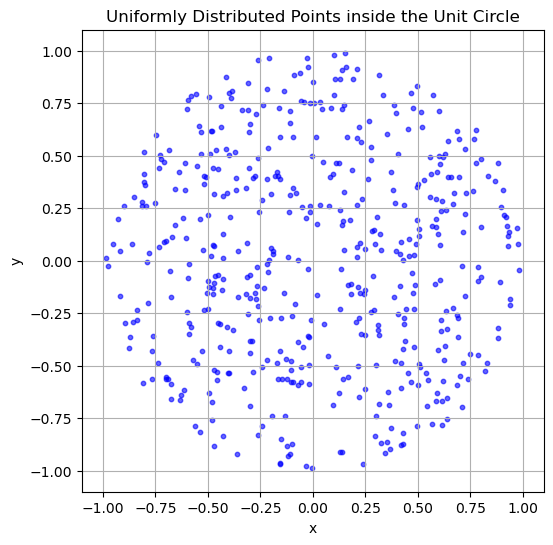

In [177]:

# Генерируем равномерно случайно радиус и углы
r = np.sqrt(np.random.rand(500))  # Корень - чтобы обеспечить равномерное распределение
theta = 2 * np.pi * np.random.rand(500)

x = r * np.cos(theta)
y = r * np.sin(theta)

plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=10, color='blue', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Uniformly Distributed Points inside the Unit Circle')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid(True)
plt.show()

### Problem 9
Prove (orally) that the following algorithm (**Box-Muller algorithm**, https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) generates a sample of independent $\mathcal{N}(0,1)$ random variables. Modify the method to exclude calls of trigonometric functions `np.sin` and `np.cos`. Using the modified method, simulate a sample size of $1000$ from a $2D$ Gaussian distribution with mean $\mu$ and covariance matrix $\Sigma$, where
$$\mu = \begin{pmatrix} 4 \\ 7 \end{pmatrix}^T, \quad \Sigma = \begin{pmatrix} 20 & -4 \\ -4 & 40 \end{pmatrix}.$$
Construct a 2D histogram of the resulting distribution. Compare the sample mean and covariance matrix with the exact values.

In [179]:
import seaborn as sns

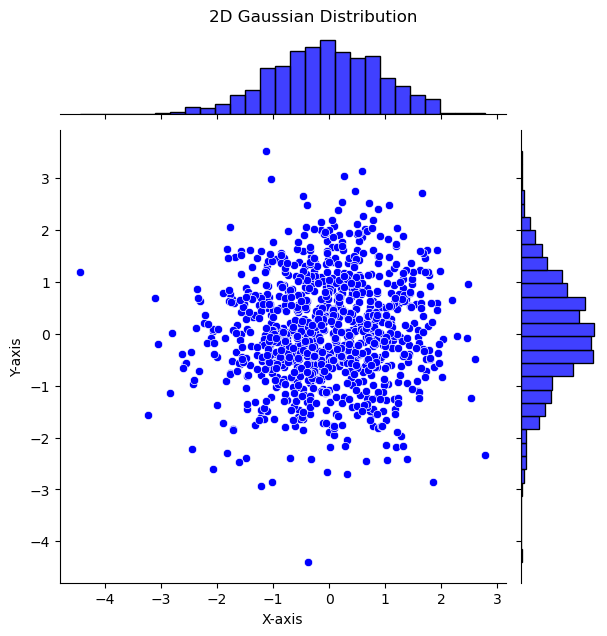

In [181]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)


joint_plot = sns.jointplot(x=x, y=y, color="blue")
joint_plot.set_axis_labels('X-axis', 'Y-axis')
plt.suptitle('2D Gaussian Distribution', y=1.02)
plt.show()

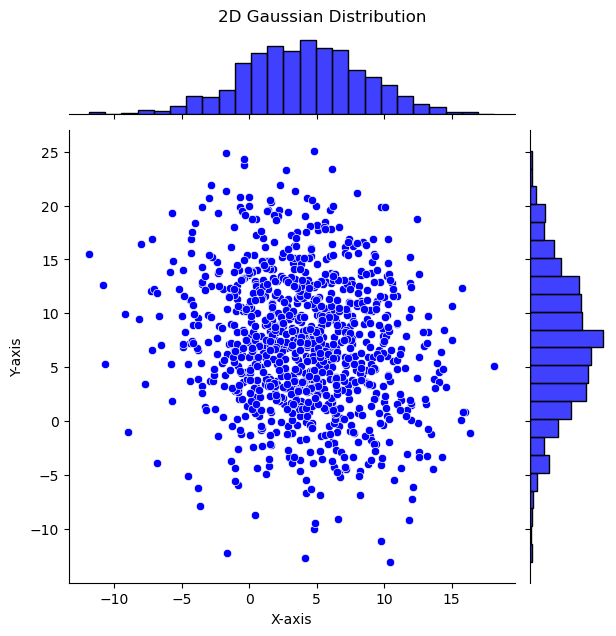

Sample Mean:
 [3.98775942 7.14400023]
Sample Covariance Matrix:
 [[20.74596238 -4.88566443]
 [-4.88566443 39.41854307]]
Exact Mean:
 [4 7]
Exact Covariance Matrix:
 [[20 -4]
 [-4 40]]


In [187]:

mu = np.array([4, 7])
Sigma = np.array([[20, -4], [-4, 40]])

# Разложение Холецкого для ковариационной матрицы
L = np.linalg.cholesky(Sigma)

# Модифицированный метод Бокса-Мюллера (Марсальи)
def marsaglia_method(n):
    Z = np.zeros((n, 2))
    count = 0
    while count < n:
        U1, U2 = np.random.uniform(-1, 1, 2)
        S = U1**2 + U2**2
        if S < 1:
            Z[count, 0] = U1 * np.sqrt(-2 * np.log(S) / S)
            Z[count, 1] = U2 * np.sqrt(-2 * np.log(S) / S)
            count += 1
    return Z

Z = marsaglia_method(1000)

# Преобразуем в заданное распределение
X = mu + np.dot(Z, L.T)

joint_plot = sns.jointplot(x=X[:, 0], y=X[:, 1], color="blue")
joint_plot.set_axis_labels('X-axis', 'Y-axis')
plt.suptitle('2D Gaussian Distribution', y=1.02)
plt.show()

# Вычисляем выборочное среднее и ковариационную матрицу
sample_mean = np.mean(X, axis=0)
sample_cov = np.cov(X, rowvar=False)

print("Sample Mean:\n", sample_mean)
print("Sample Covariance Matrix:\n", sample_cov)
print("Exact Mean:\n", mu)
print("Exact Covariance Matrix:\n", Sigma)

### Problem 10*

Implement a method of generating a random partition of an n-element set into subsets. Use it to estimate the expected number of subsets in a random partition of a set of 100 elements.

Hint 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Hint 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [ ]:
# Your code here